## Forge Configuration

In [1]:
# conda activate kgforge
import getpass
import yaml
import pandas as pd
import numpy as np
import nexussdk as nxs
from kgforge.core import KnowledgeGraphForge
from kgforge.core import Resource

In [2]:
ORGANIZATION = "fusion-adulbrich" # choose your fusion org
PROJECT = "Flower-Classification" # choose your newly created fusion project
DEPLOYMENT = "https://staging.nexus.ocp.bbp.epfl.ch/v1"

In [4]:
TOKEN = getpass.getpass()

 ·······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

In [5]:
context = {
  "@id": "https://context.org",
  "@context": {
    "@vocab": "https://staging.nexus.ocp.bbp.epfl.ch/v1/vocabs/",
    "schema": "http://schema.org/",
    "prov": "http://www.w3.org/ns/",
    "description": {
      "@id": "http://schema.org/description"
    },
    "name": {
      "@id": "http://schema.org/name"
    },
    "used": {
      "@id": "http://www.w3.org/ns/prov#used"
    },
    "generated": {
      "@id": "http://www.w3.org/ns/prov#generated"
    }
  }
}

In [6]:
nxs.config.set_environment(DEPLOYMENT)
nxs.config.set_token(TOKEN)
#nxs.resources.create(ORGANIZATION, PROJECT, context) #to run the first time if no context exists in your project

In [7]:
config = {
    "Model": {
        "name": "RdfModel",
        "origin": "store",
        "source": "BlueBrainNexus",
        "context": {
            "iri": "https://context.org",
            "bucket": f"{ORGANIZATION}/{PROJECT}"
        }
    },
    "Store": {
        "name": "BlueBrainNexus",
        "endpoint": DEPLOYMENT,
        "versioned_id_template": "{x.id}?rev={x._store_metadata._rev}",
        "file_resource_mapping": "https://raw.githubusercontent.com/BlueBrain/nexus-forge/master/examples/configurations/nexus-store/file-to-resource-mapping.hjson",
    }
}

In [8]:
forge = KnowledgeGraphForge(config, token=TOKEN, bucket=f"{ORGANIZATION}/{PROJECT}")

## Step 1: Data Analysis

In [10]:
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [15]:
dataset = pandas.read_csv('iris.csv')
dataset

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


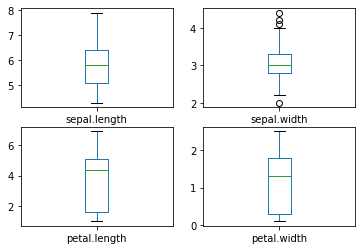

In [35]:
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.savefig('boxplot.png')

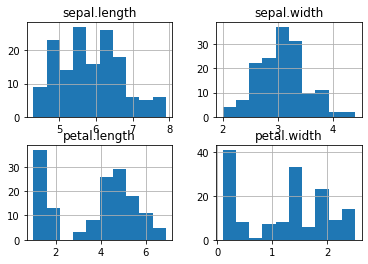

In [36]:
dataset.hist()
plt.savefig('histogram.png')

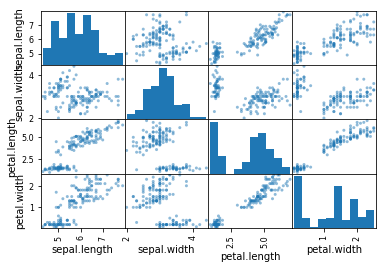

In [37]:
scatter_matrix(dataset)
plt.savefig('scatter_matrix.png')

### Register Datasets and Activity for Step 1

In [42]:
# input of step 1, 2, 3
myfile = forge.attach("./iris.csv")
mydataset = Resource(type="http://schema.org/Dataset", name="Iris Dataset 1" , distribution=myfile)
forge.register(mydataset)

<action> _register_one
<succeeded> True


In [38]:
# output of step 1
myboxplot = forge.attach("./boxplot.png")
myboxplotdataset = Resource(type="http://schema.org/Dataset", name="Iris Boxplot" , distribution=myboxplot)
forge.register(myboxplotdataset)

<action> _register_one
<succeeded> True


In [39]:
# output of step 1
myhistogram = forge.attach("./histogram.png")
myhistogramdataset = Resource(type="http://schema.org/Dataset", name="Iris Histogram" , distribution=myhistogram)
forge.register(myhistogramdataset)

<action> _register_one
<succeeded> True


In [40]:
# output of step 1
myscatter = forge.attach("./scatter_matrix.png")
myscatterdataset = Resource(type="http://schema.org/Dataset", name="Iris Scatter Matrix" , distribution=myscatter)
forge.register(myscatterdataset)

<action> _register_one
<succeeded> True


In [44]:
# activity of step 1: link manually in Fusion
myfirstactivity = Resource(type="http://www.w3.org/ns/prov#Activity", name="Data Analysis", used=mydataset, generated=[myboxplotdataset,myhistogramdataset,myscatterdataset])
forge.register(myfirstactivity) #does not work if the resource has an array of type [..., ...]

<action> _register_one
<succeeded> True


## Step 2: Build Models

### Train and Test Sets

In [54]:
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

### Models Definition and Running

In [55]:
scoring = 'accuracy'

In [82]:
%%capture cap --no-stderr
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=500)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
 kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
 cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)

In [83]:
with open('models.txt', 'w') as f:
    f.write(cap.stdout)

### Register Datasets and Activity for Step 2

In [70]:
# input of step 2
mymodels = forge.attach("./models.txt")
mymodelsdataset = Resource(type="http://schema.org/Dataset", name="Models", distribution=mymodels)
forge.register(mymodelsdataset)

<action> _register_one
<succeeded> True


In [71]:
# input of step 2
myconfigdataset = Resource(type="http://schema.org/Dataset", name="Models Configuration", seed=seed, validation_size=validation_size, scoring=scoring)
forge.register(myconfigdataset)

<action> _register_one
<succeeded> True


In [72]:
# output of step 2, input of step 3
myaccuracies = forge.attach("./accuracies.txt")
myaccuraciesdataset = Resource(type="http://schema.org/Dataset", name="Models Accuracy", distribution=myaccuracies)
forge.register(myaccuraciesdataset)

<action> _register_one
<succeeded> True


In [74]:
# activity of step 2: link manually in Fusion
mysecondactivity = Resource(type="http://www.w3.org/ns/prov#Activity", name="Models Generation", used=[mydataset,mymodelsdataset,myconfigdataset], generated=myaccuraciesdataset) 
forge.register(mysecondactivity)

<action> _register_one
<succeeded> True


## Step 3: Validation

In [84]:
%%capture cap --no-stderr
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [85]:
with open('knn-results.txt', 'w') as f:
    f.write(cap.stdout)

In [86]:
%%capture cap --no-stderr
lr = LogisticRegression(solver='lbfgs', max_iter=500)
lr.fit(X_train, Y_train)
predictions = lr.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [87]:
with open('lr-results.txt', 'w') as f:
    f.write(cap.stdout)

In [88]:
%%capture cap --no-stderr
svn = SVC()
svn.fit(X_train, Y_train)
predictions = svn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [89]:
with open('svn-results.txt', 'w') as f:
    f.write(cap.stdout)

### Register Datasets and Activity for Step 3

In [90]:
# output of step 3
myknn = forge.attach("./knn-results.txt")
myknndataset = Resource(type="http://schema.org/Dataset", name="kNN Results", distribution=myknn)
forge.register(myknndataset)

<action> _register_one
<succeeded> True


In [91]:
# output of step 3
mylr = forge.attach("./lr-results.txt")
mylrdataset = Resource(type="http://schema.org/Dataset", name="Logitic Regression Results", distribution=mylr)
forge.register(mylrdataset)

<action> _register_one
<succeeded> True


In [92]:
# output of step 3
mysvn = forge.attach("./svn-results.txt")
mysvndataset = Resource(type="http://schema.org/Dataset", name="Logitic Regression Results", distribution=mysvn)
forge.register(mysvndataset)

<action> _register_one
<succeeded> True


In [93]:
# activity of step 3: link manually in Fusion
mythirdactivity = Resource(type="http://www.w3.org/ns/prov#Activity", name="Results of Best Models", used=[mydataset,myconfigdataset,myaccuraciesdataset], generated=[myknndataset, mylrdataset, mysvndataset]) 
forge.register(mythirdactivity)

<action> _register_one
<succeeded> True
